In [1]:
%load_ext tensorboard

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
import numpy as np
import math as math
import datetime as datetime

2024-02-18 14:33:29.111832: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-18 14:33:29.111910: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-18 14:33:29.168494: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-18 14:33:29.290189: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [23]:
labels = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

train = pd.read_csv('data/fashion-mnist_train.csv')
test = pd.read_csv('data/fashion-mnist_test.csv')

# Splitting training data into X and y
X = train.drop('label', axis=1)
y = train['label']

# Normalizing data
X = X / 255.0
X = X.to_numpy().reshape(X.shape[0], 28, 28, 1)

# Split data into training and validation
X_train, X_validation, y_train, y_validation = X[:50000], X[50000:], y[:50000], y[50000:]

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
  zoom_range=[0.75, 1],
)

datagen.fit(X_train)

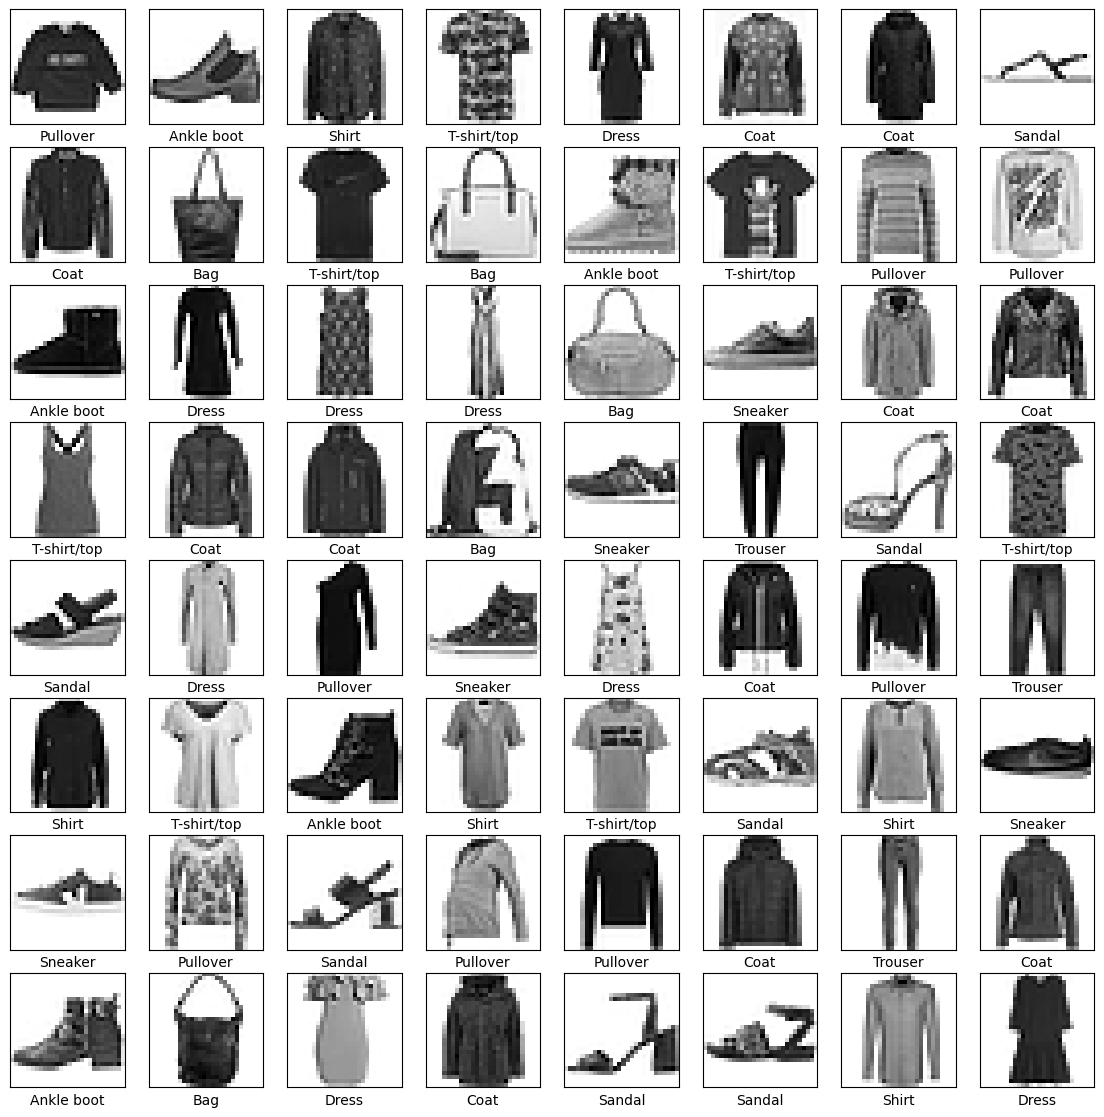

In [4]:
# Visualize data
visualize = 64
num_cells = math.ceil(math.sqrt(visualize))
plt.figure(figsize=(14, 14))

for i in range(visualize):
  plt.subplot(num_cells, num_cells, i + 1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(X[i], cmap=plt.cm.binary)
  plt.xlabel(labels[y[i]])

In [24]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28, 28, 1)),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])

print(model.summary())

model.compile(optimizer='adam', loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 13, 13, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 5, 5, 64)          0         
 ng2D)                                                           
                                                                 
 flatten_5 (Flatten)         (None, 1600)              0         
                                                                 
 dropout_5 (Dropout)         (None, 1600)             

In [ ]:
%tensorboard --logdir logs/fit

In [26]:
!rm -rf ./logs/

# Tensorflow board
logs_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logs_dir, histogram_freq=1)

data_gen_train = datagen.flow(X_train, y_train, batch_size=64)

# Train model
model.fit(data_gen_train, 
          epochs=100, 
          validation_data=(X_validation, y_validation), 
          callbacks=[tensorboard_callback], 
          batch_size=64, 
          steps_per_epoch=int(np.ceil(50000 / float(64))),
          validation_steps=int(np.ceil(10000 / float(64)))
          )
print("model has been trained")

Epoch 1/100
782/782 [==============================] - 14s 18ms/step - loss: 0.1548 - accuracy: 0.9403 - val_loss: 0.3138 - val_accuracy: 0.9060
Epoch 2/100
782/782 [==============================] - 14s 18ms/step - loss: 0.1549 - accuracy: 0.9412 - val_loss: 0.2891 - val_accuracy: 0.9106
Epoch 3/100
782/782 [==============================] - 14s 18ms/step - loss: 0.1545 - accuracy: 0.9419 - val_loss: 0.2996 - val_accuracy: 0.9088
Epoch 4/100
782/782 [==============================] - 14s 17ms/step - loss: 0.1497 - accuracy: 0.9433 - val_loss: 0.3154 - val_accuracy: 0.9036
Epoch 5/100
782/782 [==============================] - 13s 17ms/step - loss: 0.1508 - accuracy: 0.9438 - val_loss: 0.2937 - val_accuracy: 0.9058
Epoch 6/100
782/782 [==============================] - 14s 17ms/step - loss: 0.1505 - accuracy: 0.9426 - val_loss: 0.3397 - val_accuracy: 0.9032
Epoch 7/100
782/782 [==============================] - 13s 17ms/step - loss: 0.1493 - accuracy: 0.9431 - val_loss: 0.3008 - val_ac

In [27]:
model.save('builds/v3/model.h5')
!tensorflowjs_converter --input_format keras ./builds/v3/model.h5 ./builds/v3/tensorflowjs

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2024-02-18 19:04:55.186060: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-18 19:04:55.186188: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-18 19:04:55.235018: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [30]:
for imagenes_prueba, etiquetas_prueba in test.take(1):
  imagenes_prueba = imagenes_prueba.numpy()
  etiquetas_prueba = etiquetas_prueba.numpy()
  predicciones = model.predict(imagenes_prueba)
  
def graficar_imagen(i, arr_predicciones, etiquetas_reales, imagenes):
  arr_predicciones, etiqueta_real, img = arr_predicciones[i], etiquetas_reales[i], imagenes[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img[...,0], cmap=plt.cm.binary)

  etiqueta_prediccion = np.argmax(arr_predicciones)
  if etiqueta_prediccion == etiqueta_real:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(labels[etiqueta_prediccion],
                                100*np.max(arr_predicciones),
                                labels[etiqueta_real]),
                                color=color)
  
def graficar_valor_arreglo(i, arr_predicciones, etiqueta_real):
  arr_predicciones, etiqueta_real = arr_predicciones[i], etiqueta_real[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  grafica = plt.bar(range(10), arr_predicciones, color="#777777")
  plt.ylim([0, 1]) 
  etiqueta_prediccion = np.argmax(arr_predicciones)
  
  grafica[etiqueta_prediccion].set_color('red')
  grafica[etiqueta_real].set_color('blue')
  
filas = 5
columnas = 5
num_imagenes = filas*columnas
plt.figure(figsize=(2*2*columnas, 2*filas))
for i in range(num_imagenes):
  plt.subplot(filas, 2*columnas, 2*i+1)
  graficar_imagen(i, predicciones, etiquetas_prueba, imagenes_prueba)
  plt.subplot(filas, 2*columnas, 2*i+2)
  graficar_valor_arreglo(i, predicciones, etiquetas_prueba)

ValueError: too many values to unpack (expected 2)